# Det2stoc algorithm

1. **Data<sub>sim</sub>** `[previous_state, action, next_state, params]` is collected from MuJoCo with varying mass parameters in each episode
1. **Data<sub>real</sub>** `[previous_state, action, next_state]` is collected from the real robot (or some specific configuration of MuJoCo representing our desired "hidden" state)
1. A network **D** is trained on **Data<sub>sim</sub>** to match the output of MuJoCo `[next_state]` with inputs `[mass_param, previous_state, action]`
1. **D** is used as decoder to train a **CVAE** on **Data<sub>real</sub>** with inputs `[next_state]` conditioned on `[previous_state, action]`
1. **D** is again trained to output the next state on **Data<sub>sim</sub>**, except this time the `mass_param` is replaced by sampling latent variables from the encoder (how?) such that inputs become `[N(phi_mu, phi_sigma), previous_state, action]`
1. ?

In [1]:
import numpy as np
np.set_printoptions(precision=4)

import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.contrib.layers import fully_connected
import tensorflow_probability as tfp
tfd = tfp.distributions

%matplotlib inline
sns.set(palette='husl')

seed = 8
np.random.seed(seed)
tf.set_random_seed(seed)
# config = tf.ConfigProto()
# config.gpu_options.allow_growth = True

In [2]:
n_trials = 50
n_epochs_decoder = 30000
n_epochs_cvae = 1000
batch_size = 1000

PREPROCESS = 0

In [3]:
#model_name = 'lunar'
model_name = 'mujoco'

if model_name == 'lunar':
    with open('./data_1000_lunar_uniform.npz', 'rb') as f:
        data = np.load(f)
    with open('./data_100_lunar_real.npz', 'rb') as f:
        real_data = np.load(f)
else:
    with open('../catkin/data_1000_mass0.3-1.2.npz', 'rb') as f:
        data = np.load(f)
    with open('../catkin/data_real100_mass1.1.npz', 'rb') as f:
        real_data = np.load(f)

print(data.shape)

(77023, 5)


In [4]:
n_states = len(data[0][0])
n_inputs = n_outputs = n_states
n_codings = 1
mixture_components = 1
n_params = 1
n_actions = len(data[0][1])
print('states: ', n_states)
print('actions: ', n_actions)
n_conditions = n_actions + n_states

states:  88
actions:  14


In [5]:
states = np.array([d[0][:n_states].ravel() for d in data])
actions = np.array([d[1].ravel() for d in data])
print(actions.shape)
next_states = np.array([d[2][:n_states].ravel() for d in data])
print(next_states.shape)
params = np.array([[d[3]] for d in data]).squeeze().reshape(-1, 1)

real_states = np.array([d[0][:n_states].ravel() for d in real_data])
real_actions = np.array([d[1].ravel() for d in real_data])
real_next_states = np.array([d[2][:n_states].ravel() for d in real_data])

try:
    real_params = np.array([d[3] for d in real_data]).squeeze()
except:
    real_params = np.ones(len(real_data))
real_params = real_params.reshape(-1, 1)
assert np.allclose(real_params.min(), real_params.max())

(77023, 14)
(77023, 88)


In [6]:
def normalize(a):
    r = a.copy()
    r -= np.min(a, axis=0)
    r /= np.ptp(a, axis=0)
    return r

def standardize(a):
    r = a.copy()
    r -= a.mean(axis=0)
    r /= a.std(axis=0)
    return r

if PREPROCESS:

    states_n = normalize(states)
    next_states_n = normalize(next_states)

    # standardize state/next_state together
    # all_states = np.vstack([states, next_states])
    # mean = all_states.mean(axis=0)
    # std = all_states.std(axis=0)

    # states_n = (states-mean)/std
    # next_states_n = (next_states-mean)/std
    # real_states = (real_states-mean)/std
    # real_next_states = (real_next_states-mean)/std
else:
    # no preprocessing at all
    states_n = states
    next_states_n = next_states

params min:  [0.3002]
params max:  [1.1992]
params ptp:  [0.8989]


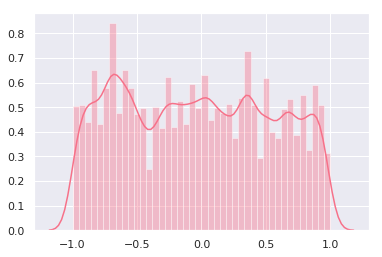

In [7]:
params_min = np.min(params, axis=0)
params_max = np.max(params, axis=0)
params_ptp = np.ptp(params, axis=0)
print('params min: ', params_min)
print('params max: ', params_max)
print('params ptp: ', params_ptp)
params_from, params_to = -1, 1
params = params_from + (params_to-params_from)*(params - params_min) / params_ptp

sns.distplot(params)

In [8]:
next_states_n = next_states_n - states_n
real_next_states = real_next_states - real_states

In [9]:
n_data = len(data)

# Shuffle
data = np.random.permutation(data)

split = int(n_data * 0.8)

states_n_train, states_n_test = states_n[:split], states_n[split:]
actions_train, actions_test = actions[:split], actions[split:]
next_states_n_train, next_states_n_test = next_states_n[:split], next_states_n[split:]
params_train, params_test = params[:split].reshape(-1, 1), params[split:].reshape(-1, 1)

split = int(len(real_data) * 0.8)
real_states_train, real_states_test = real_states[:split], real_states[split:]
real_actions_train, real_actions_test = real_actions[:split], real_actions[split:]
real_next_states_train, real_next_states_test = real_next_states[:split], real_next_states[split:]
real_params_train, real_params_test = real_params[:split], real_params[split:]

samples2plot = np.random.choice(len(states_n_test), 30)
real_samples2plot = np.random.choice(len(real_states_test), 30)

# Plot functions

In [10]:
def boxplot(x_data, y_data, base_color='#77CCBB', median_color='#FC7382', x_label='', y_label='', title=''):
    _, ax = plt.subplots(figsize=(16,8), facecolor='w')

    ax.boxplot(y_data,
               medianprops = {'color': median_color},
               boxprops = {'color': base_color},
               whiskerprops = {'color': base_color},
               capprops = {'color': base_color},
               showfliers=False)

    ax.set_ylabel(y_label)
    ax.set_xlabel(x_label)
    ax.set_title(title)
    return ax

In [11]:
def sample_and_plot(samples, s, a, ns, state_idx=0, n_trials=50, plot_previous_state=False):
    n_samples = len(s)

    outputs = np.empty((n_samples, n_trials, n_outputs))

    for i in range(n_samples):
        states = np.tile(s[i], [n_trials, 1])
        actions = np.tile(a[i], [n_trials, 1])
        out = sess.run(samples, feed_dict={STATES: states, ACTIONS: actions, BATCH_SIZE: len(states)})
        outputs[i] = out
    
    ax = boxplot(range(len(outputs)), outputs[:,:,state_idx].T, x_label='Sample#', y_label='State value', 
             title='Prediction estimates and actual values for state index: {}.'
             'The colored dots correspond to the true next state for a particular sample.'.format(state_idx))

    for i in range(n_samples):
        # Box plot always starts from 1
        x = i+1
        y = ns[i,state_idx]
        ax.plot(x, y, marker='o', label='true value')

    plt.show()

In [12]:
def sample_and_plot_pretrained_decoder(samples, s, a, ns, p, state_idx=0, n_trials=50):
    n_samples = len(s)

    outputs = np.empty((n_samples, n_trials, n_outputs))

    for i in range(n_samples):
        param = p[i].reshape(1, -1)
        param = np.tile(p[i], [n_trials, 1])
        si = np.tile(s[i], [n_trials, 1])
        ai = np.tile(a[i], [n_trials, 1])
        feed_dict = {STATES: si, ACTIONS: ai, Z: param}
        out = sess.run(samples, feed_dict).reshape(n_trials, n_outputs)
        outputs[i] = out
    
    ax = boxplot(range(len(outputs)), outputs[:,:,state_idx].T, x_label='Sample#', y_label='State value', 
             title='Prediction estimates and actual values for state index: {}.'
             'The colored dots correspond to the true next state for a particular sample.'.format(state_idx))

    for i in range(n_samples):
        # Box plot always starts from 1
        x = i+1
        y = ns[i,state_idx]
        ax.plot(x, y, marker='o', label='true value')

    plt.show()

In [13]:
def plot_posterior(posterior):
    posterior_mean, posterior_var = sess.run([posterior.mean(), posterior.variance()], 
                                             feed_dict={STATES: real_states, ACTIONS: real_actions, Y: real_next_states})

    param = (posterior_mean[:,0] - params_from) * params_ptp/(params_to-params_from) + params_min
    sns.distplot(param)
    real_param = real_params[0]
    plt.xlim(real_param-1,real_param+1)
    plt.axvline(real_param, label='True param from real data', color='g')
    print('Param approx mean: ', param.mean())

In [14]:
def sample_with_choice(choice, states=states_n_test, actions=actions_test, next_states=next_states_n_test, params=params_test, n_codings=n_codings):
    s = np.take(states, choice, axis=0)
    a = np.take(actions, choice, axis=0)
    ns = np.take(next_states, choice, axis=0)
    p = np.take(params, choice, axis=0)
    c = np.random.normal(size=[len(choice), n_codings])# sess.run(prior.sample(len(choice)))
    c[:,0] = p.reshape(-1)
    return s, a, ns, c

# CVAE

In [15]:
def softplus_inverse(x):
    return tf.log(tf.expm1(x))

def normalize(inp, activation, reuse, scope, norm='None'):
    if norm == 'batch_norm':
        return tf_layers.batch_norm(inp, activation_fn=activation, reuse=reuse, scope=scope)
    elif norm == 'layer_norm':
        return tf_layers.layer_norm(inp, activation_fn=activation, reuse=reuse, scope=scope)
    elif norm == 'None':
        if activation is not None:
            return activation(inp)
        else:
            return inp

dim_hidden=[100]*3

def encoder_weights(n_codings=n_codings, dim_hidden=dim_hidden, stddev=1e-2):
    weights = {}
    with tf.variable_scope('encoder'):
        weights['w1'] = tf.Variable(tf.truncated_normal([n_conditions+n_outputs, dim_hidden[0]], stddev=stddev))
        weights['b1'] = tf.Variable(tf.zeros([dim_hidden[0]]))
        for i in range(1,len(dim_hidden)):
            weights['w'+str(i+1)] = tf.Variable(tf.truncated_normal([dim_hidden[i-1], dim_hidden[i]], stddev=stddev))
            weights['b'+str(i+1)] = tf.Variable(tf.zeros([dim_hidden[i]]))
        # Need mu and sigma, so n_codings*2
        weights['w'+str(len(dim_hidden)+1)] = tf.Variable(tf.truncated_normal([dim_hidden[-1], n_codings*2], stddev=stddev))
        weights['b'+str(len(dim_hidden)+1)] = tf.Variable(tf.zeros([n_codings*2]))
    return weights

def encoder_forward(X, Y, weights, reuse=False, activation=tf.nn.relu, dim_hidden=dim_hidden):
    inp = tf.concat([X, Y], axis=1)
    with tf.variable_scope('encoder'):
        hidden = normalize(tf.matmul(inp, weights['w1']) + weights['b1'], activation=activation, reuse=reuse, scope='0')
        for i in range(1,len(dim_hidden)):
            hidden = normalize(tf.matmul(hidden, weights['w'+str(i+1)]) + weights['b'+str(i+1)], activation=activation, reuse=reuse, scope=str(i+1))
        out = tf.matmul(hidden, weights['w'+str(len(dim_hidden)+1)]) + weights['b'+str(len(dim_hidden)+1)]
        mu = out[...,  :n_codings]
        log_var = tf.nn.softplus(out[..., n_codings:] + softplus_inverse(1.0))
        return mu, log_var
    
def make_prior(mixture_components, code_size):
    with tf.variable_scope('prior'):
        if mixture_components == 1 and False:
            return tfd.MultivariateNormalDiag(
                loc=tf.zeros([code_size]), 
                scale_identity_multiplier=1.0)

        loc = tf.get_variable(name="loc", shape=[mixture_components, code_size])
        raw_scale_diag = tf.get_variable(
          name="raw_scale_diag", shape=[mixture_components, code_size])
        mixture_logits = tf.get_variable(
          name="mixture_logits", shape=[mixture_components])

        return tfd.MixtureSameFamily(
          components_distribution=tfd.MultivariateNormalDiag(
              loc=loc,
              scale_diag=tf.nn.softplus(raw_scale_diag)),
          mixture_distribution=tfd.Categorical(logits=mixture_logits),
          name="prior")

def cvae_prior_weights(mixture_components=1, n_codings=1, dim_hidden=dim_hidden, stddev=1e-2):
    weights = {}
    with tf.variable_scope('prior'):
        weights['w1'] = tf.Variable(tf.truncated_normal([n_conditions+n_outputs, dim_hidden[0]], stddev=stddev))
        weights['b1'] = tf.Variable(tf.zeros([dim_hidden[0]]))
        for i in range(1,len(dim_hidden)):
            weights['w'+str(i+1)] = tf.Variable(tf.truncated_normal([dim_hidden[i-1], dim_hidden[i]], stddev=stddev))
            weights['b'+str(i+1)] = tf.Variable(tf.zeros([dim_hidden[i]]))
        # Need mu and sigma
        prior_dim = 2*np.prod([mixture_components, n_codings]) + mixture_components
        weights['w'+str(len(dim_hidden)+1)] = tf.Variable(tf.truncated_normal([dim_hidden[-1], prior_dim], stddev=stddev))
        weights['b'+str(len(dim_hidden)+1)] = tf.Variable(tf.zeros([prior_dim]))
        return weights

def make_cvae_prior(X, Yhat, weights, mixture_components=1, n_codings=1, activation=tf.nn.relu, reuse=False, prefix=''):
    with tf.variable_scope('prior'):
        
        inp = tf.concat(axis=1, values=[X, Yhat])
        hidden = normalize(tf.matmul(inp, weights[prefix+'w1']) + weights[prefix+'b1'], activation=activation, reuse=reuse, scope='0')
        for i in range(1,len(dim_hidden)):
            hidden = normalize(tf.matmul(hidden, weights[prefix+'w'+str(i+1)]) + weights[prefix+'b'+str(i+1)], activation=activation, reuse=reuse, scope=str(i+1))
        out = tf.matmul(hidden, weights[prefix+'w'+str(len(dim_hidden)+1)]) + weights[prefix+'b'+str(len(dim_hidden)+1)]
        locdim = np.prod([mixture_components, n_codings])
        loc = out[..., :locdim]
        loc = tf.reshape(loc, [-1, mixture_components, n_codings])
        scale = out[..., locdim:locdim*2]
        scale = tf.reshape(scale, [-1, mixture_components, n_codings])
        mixture = out[..., -mixture_components:]
        mixture = tf.reshape(mixture, [-1, mixture_components])
        out = tfd.MixtureSameFamily(
          components_distribution=tfd.MultivariateNormalDiag(
              loc=loc,
              scale_diag=tf.nn.softplus(scale)),
          mixture_distribution=tfd.Categorical(logits=tf.nn.softmax(mixture)),
          name="prior")
        return out

def decoder_weights(n_codings=n_codings, dim_hidden=dim_hidden, prefix='decoder', stddev=1e-2):
    weights = {}
    with tf.variable_scope('decoder'):
        weights[prefix+'w1'] = tf.Variable(tf.truncated_normal([n_codings+n_conditions, dim_hidden[0]-1], stddev=stddev))
        weights[prefix+'b1'] = tf.Variable(tf.zeros([dim_hidden[0]-1]))
        for i in range(1,len(dim_hidden)):
            weights[prefix+'w'+str(i+1)] = tf.Variable(tf.truncated_normal([dim_hidden[i-1], dim_hidden[i]-1], stddev=stddev))
            weights[prefix+'b'+str(i+1)] = tf.Variable(tf.zeros([dim_hidden[i]-1]))
        weights[prefix+'w'+str(len(dim_hidden)+1)] = tf.Variable(tf.truncated_normal([dim_hidden[-1], n_outputs*2], stddev=stddev))
        weights[prefix+'b'+str(len(dim_hidden)+1)] = tf.Variable(tf.zeros([n_outputs*2]))
    return weights

# def decoder_forward(prior, condition, weights, reuse=False, activation=tf.nn.relu, dim_hidden=dim_hidden, prefix='decoder_'):
def decoder_forward(prior, condition, weights, reuse=False, activation=tf.nn.relu, dim_hidden=dim_hidden, prefix='decoder'):
    inp = tf.concat(axis=1, values=[prior, condition])
    hidden = normalize(tf.matmul(inp, weights[prefix+'w1']) + weights[prefix+'b1'], activation=activation, reuse=reuse, scope='0')
    for i in range(1,len(dim_hidden)):
        hidden = normalize(tf.matmul(tf.concat(axis=1, values=[prior, hidden]), weights[prefix+'w'+str(i+1)]) + weights[prefix+'b'+str(i+1)], activation=activation, reuse=reuse, scope=str(i+1))
    out = tf.matmul(tf.concat(axis=1, values=[prior, hidden]), weights[prefix+'w'+str(len(dim_hidden)+1)]) + weights[prefix+'b'+str(len(dim_hidden)+1)]
    mu = out[...,:n_outputs]
    logvar = tf.nn.softplus(out[...,n_outputs:] + softplus_inverse(1.0))
    out = tfd.MultivariateNormalDiag(mu, logvar)
    return out

make_prior = tf.make_template('prior', make_prior)
make_cvae_prior = tf.make_template('cvae_prior', make_cvae_prior)

# Training

In [16]:
STATES = tf.placeholder(tf.float32, [None, n_states], name='STATES')
ACTIONS = tf.placeholder(tf.float32, [None, n_actions], name='ACTIONS')
X = tf.concat([STATES, ACTIONS], axis=1, name='X')
Y = tf.placeholder(tf.float32, [None, n_outputs], name='Y')
Z = tf.placeholder(tf.float32, [None, n_codings], name='Z')
TRAINING = tf.Variable(False, trainable=False, name='training')
BATCH_SIZE = tf.placeholder(tf.int32, name='batch_size')

e_weights = encoder_weights()
mu, log_var = encoder_forward(X, Y, weights=e_weights)

posterior = tfd.MultivariateNormalDiag(loc=mu, scale_diag=log_var)
code = posterior.sample()

d_weights = decoder_weights()
logits = decoder_forward(code, X, d_weights)

# prior_weights = cvae_prior_weights(mixture_components, n_codings)
# prior = make_cvae_prior(X, predicted, prior_weights, mixture_components, n_codings)
prior = make_prior(mixture_components, n_codings)

decoder = decoder_forward(Z, X, d_weights, reuse=True)

cvae = decoder_forward(prior.sample(BATCH_SIZE), X, d_weights, reuse=True)
cvae_samples = cvae.sample()
                           
likelihood = logits.log_prob(value=Y)
divergence = posterior.log_prob(code) - prior.log_prob(code)
print('likelihood shape: ', likelihood)
print('divergence shape: ', divergence)

beta = 1.0
divergence *= beta
elbo = tf.reduce_mean(likelihood - divergence)
loss = -elbo


alpha = 0.8
loss_gsnn = -cvae.log_prob(Y)
loss = alpha*loss + (1-alpha)*tf.reduce_mean(loss_gsnn)

likelihood shape:  Tensor("MultivariateNormalDiag_1/log_prob/add:0", shape=(?,), dtype=float32)
divergence shape:  Tensor("sub:0", shape=(?,), dtype=float32)


# Pre-trained decoder variables

In [17]:
with tf.variable_scope('decoder'):
    decoder_loss = -tf.reduce_mean(decoder.log_prob(Y))

    decoder_global_step = tf.Variable(0, trainable=False, name='decoder-step')
    decoder_steps = n_epochs_decoder*len(states_n_train)//batch_size
    decoder_learning_rate = tf.train.cosine_decay(1e-4, decoder_global_step, decoder_steps)
    decoder_op = tf.train.AdamOptimizer(decoder_learning_rate, name='decoder-adam').minimize(decoder_loss, global_step=decoder_global_step)

In [18]:
with tf.variable_scope('encoder'):
    real_encoder_steps = n_epochs_cvae*len(real_states_train)/batch_size

    # Optimizer for CVAE
    cvae_global_step = tf.Variable(0, trainable=False, name='cvae-step')
    learning_rate = tf.train.cosine_decay(1e-6, cvae_global_step, real_encoder_steps)
    optimizer = tf.train.AdamOptimizer(learning_rate, name='cvae-adam').minimize(loss, global_step=cvae_global_step)

    # Optimizer for the encoder only
    encoder_steps = n_epochs_cvae*len(states_n_train)/batch_size
    encoder_vars = [var for var in tf.trainable_variables('encoder|prior')]
    encoder_global_step = tf.Variable(0, trainable=False, name='encoder-step')
    encoder_learning_rate = tf.train.cosine_decay(1e-3, encoder_global_step, encoder_steps)
    encoder_optimizer = tf.train.AdamOptimizer(encoder_learning_rate, name='encoder-adam').minimize(loss, var_list=encoder_vars, global_step=encoder_global_step)

# Pre-train decoder

In [19]:
def train_decoder(iterator, iterator_init_fn, decoder_op, decoder_loss, n_epochs, n_trials, samples2plot):
    global_step = []
    losses = []
    val_losses = []
    plot_step = 100

    next_batch = iterator.get_next()
    
    samples = decoder.sample()
    
    for epoch in range(n_epochs):

        iterator_init_fn()
        batch_losses = []
        while True:
            try:
                batch = sess.run(next_batch)
                s_b, a_b, ns_b, p_b = batch
                if n_params < n_codings:
                    p_b = np.hstack([p_b, np.random.normal(size=(len(p_b), n_codings-n_params))])
                feed_dict = {Y: ns_b, Z: p_b, STATES: s_b, ACTIONS: a_b, TRAINING: True}
                _, batch_loss = sess.run([decoder_op, decoder_loss], feed_dict)

                batch_losses.append(batch_loss)
            except tf.errors.OutOfRangeError:
                global_step.append(epoch)
                losses.append(np.mean(batch_losses))
                break

        if epoch % plot_step == 0 and epoch > 0:
            print('epoch: {}, loss: {:.4f}'.format(epoch, losses[-1]))
            plt.figure(figsize=(12,6))
            ax = plt.subplot(121)
            ax.plot(global_step, losses)
            ax.set_title('Learning curve.')

            ax = plt.subplot(122)
            last_steps = 20
            ax.plot(global_step[-last_steps:], losses[-last_steps:])
            ax.set_title('Learning curve last {} steps.'.format(last_steps))

            s, a, ns, c = sample_with_choice(samples2plot)
            sample_and_plot_pretrained_decoder(samples, s=s, a=a, ns=ns, p=c, n_trials=n_trials, state_idx=0)
            
            plt.show()

# CVAE

In [20]:
def train_cvae(iterator, iterator_init_fn, optimizer, loss, n_epochs, n_trials, samples2plot=None):
    global_step = []
    losses = []
    val_losses = []
    plot_step = 100

    next_batch = iterator.get_next()

    for epoch in range(n_epochs):
        
        batch_losses = []
        iterator_init_fn()
        
        while True:
            try:
                batch = sess.run(next_batch)
                s_b, a_b, ns_b, _ = batch
                feed_dict = {STATES: s_b, ACTIONS: a_b, Y: ns_b, TRAINING: True, BATCH_SIZE: len(s_b)}
                _, batch_loss = sess.run([optimizer, loss], feed_dict)
                batch_losses.append(batch_loss)
            except tf.errors.OutOfRangeError:
                break

        global_step.append(epoch)
        losses.append(np.mean(batch_losses))

        if epoch % plot_step == 0 and epoch > 0:
            print('epoch: {}, loss: {:.4f}'.format(epoch, losses[-1]))
            plt.figure(figsize=(12,6))
            ax = plt.subplot(131)
            ax.plot(global_step, losses)
            ax.set_title('Learning curve.')

            ax = plt.subplot(132)
            last_steps = 20
            ax.plot(global_step[-last_steps:], losses[-last_steps:])
            ax.set_title('Learning curve last {} steps.'.format(last_steps))

            idx = np.random.choice(len(real_states_test), batch_size)
            state_batch = real_states_test[idx]
            next_state_batch = real_next_states_test[idx]
            actions_batch = real_actions_test[idx]
            feed_dict = {STATES: state_batch, ACTIONS: actions_batch, Y: next_state_batch, BATCH_SIZE: len(state_batch)}
            curr_loss = sess.run(loss, feed_dict=feed_dict)
            val_losses.append(curr_loss)
            ax = plt.subplot(133)
            ax.plot(val_losses)
            ax.set_title('Validation learning curve.')
            
            s = np.take(real_states_test, samples2plot, axis=0)
            a = np.take(real_actions_test, samples2plot, axis=0)
            ns = np.take(real_next_states_test, samples2plot, axis=0)
            sample_and_plot(cvae_samples, s, a, ns, n_trials=n_trials, state_idx=0)
            
            plot_posterior(posterior)
            
            plt.show()

In [21]:
tensor_slices = (states_n_train, actions_train, next_states_n_train, params_train)
dataset = tf.data.Dataset.from_tensor_slices(tensor_slices).batch(batch_size)
iterator = dataset.make_initializable_iterator()
iterator_init_fn = lambda: sess.run(iterator.initializer)

tensor_slices = (real_states_train, real_actions_train, real_next_states_train, real_params_train)
real_dataset = tf.data.Dataset.from_tensor_slices(tensor_slices).batch(batch_size)
real_iterator = real_dataset.make_initializable_iterator()
real_iterator_init_fn = lambda: sess.run(real_iterator.initializer)

# Train on a variety of parameters (sim data)

In [22]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

INFO:tensorflow:Restoring parameters from ./checkpoints/model-mujoco-dim3-n_codings1-mix1-skip.ckpt


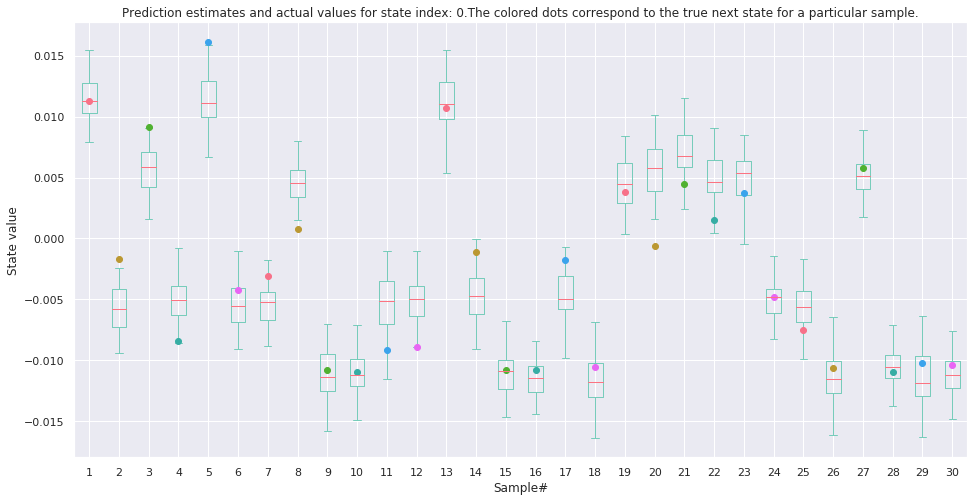

In [23]:
restore = True
path = './checkpoints/model-{}-dim{}-n_codings{}-mix{}-skip.ckpt'.format(model_name, len(dim_hidden), n_codings, mixture_components)
trainable_vars = [v for v in tf.trainable_variables(scope='decoder|predictor')]
saver = tf.train.Saver(trainable_vars)
if restore:
    saver.restore(sess, path)
    s, a, ns, c = sample_with_choice(samples2plot)
    sample_and_plot_pretrained_decoder(decoder.sample(), s=s, a=a, ns=ns, p=c, n_trials=n_trials, state_idx=0)   
else:
    train_decoder(iterator, iterator_init_fn, decoder_op, decoder_loss, n_epochs_decoder, n_trials, samples2plot)
    saver.save(sess, path)

epoch: 100, loss: 17646.4434


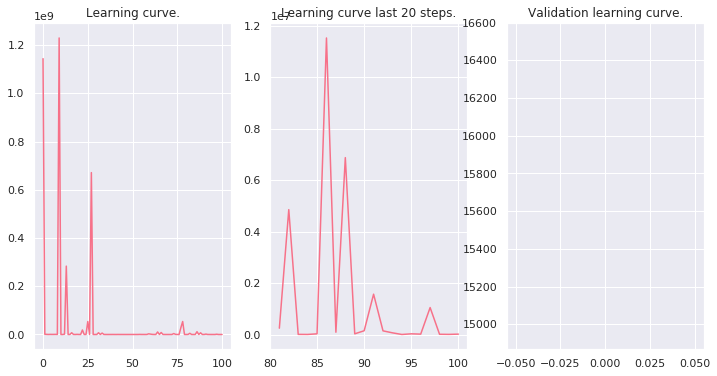

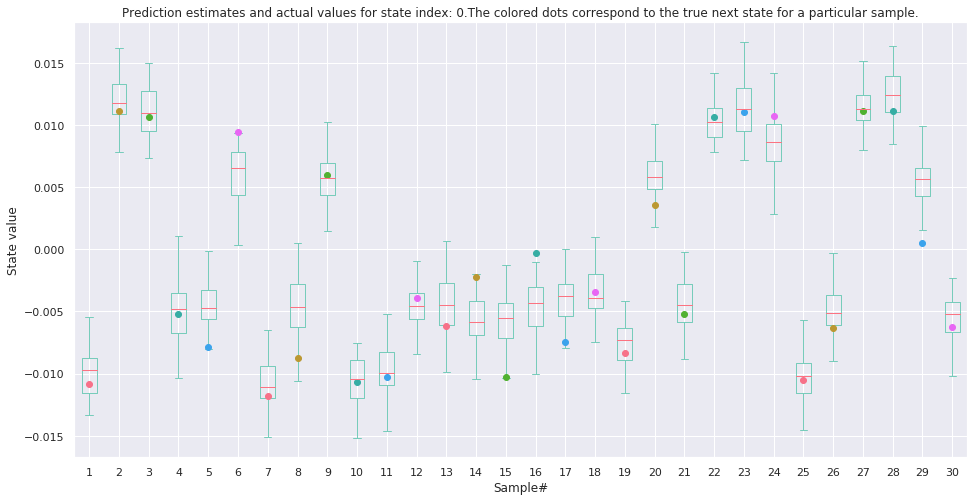

Param approx mean:  0.5563016473873932


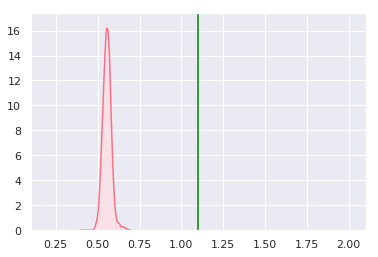

epoch: 200, loss: 4081.8098


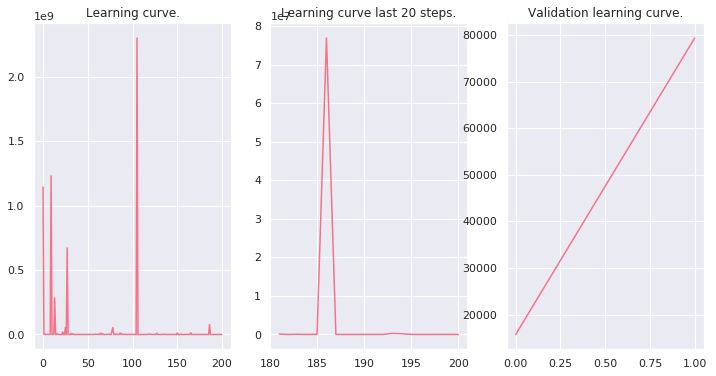

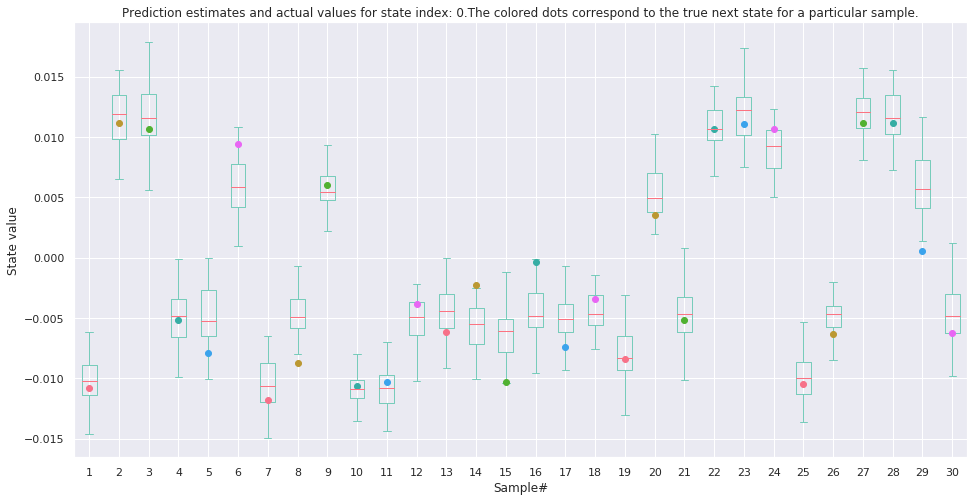

Param approx mean:  0.6583320102307889


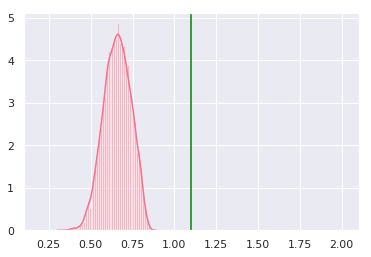

epoch: 300, loss: 1533721.8750


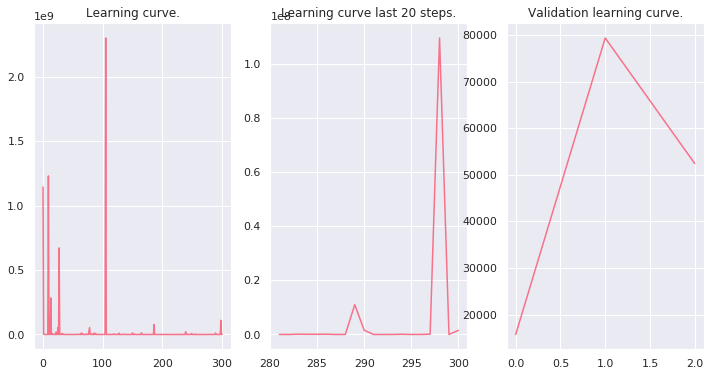

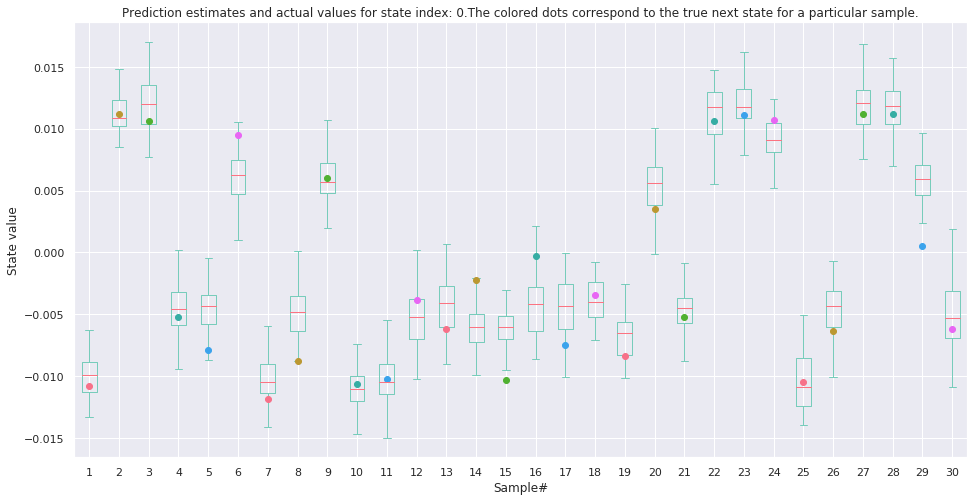

Param approx mean:  0.73260216359092


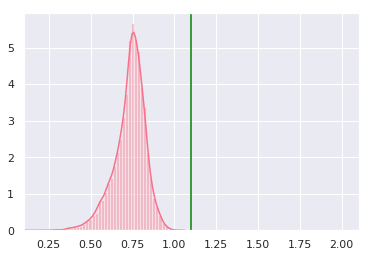

epoch: 400, loss: 8806.8242


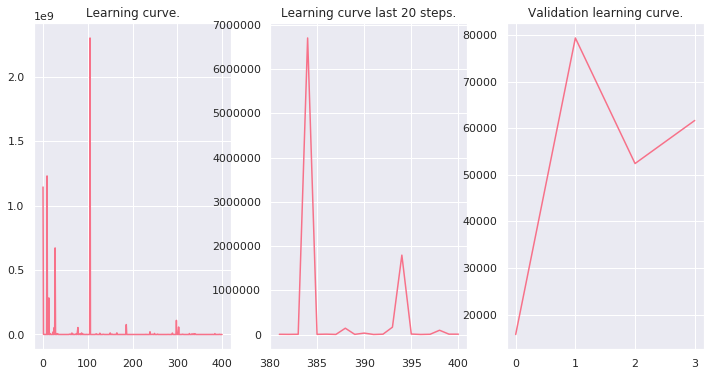

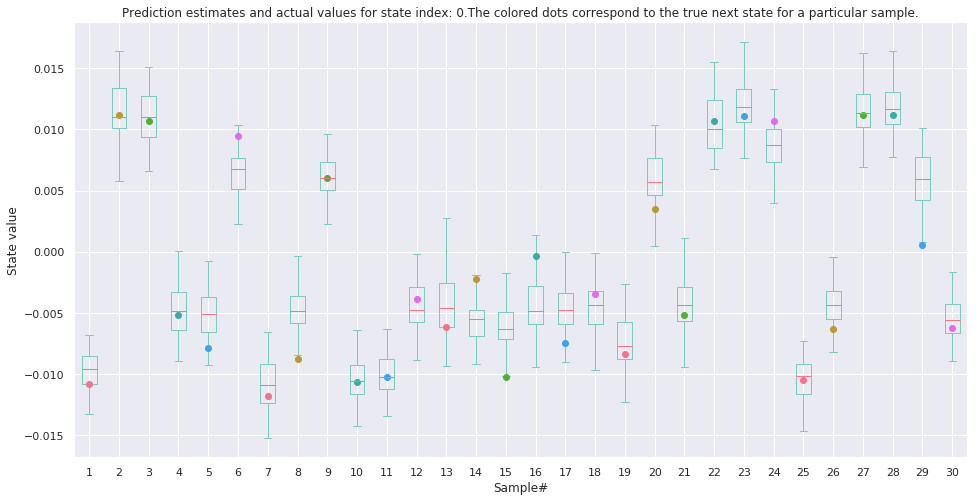

Param approx mean:  0.8151030648123497


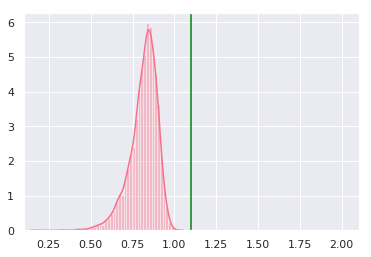

epoch: 500, loss: 136004.8594


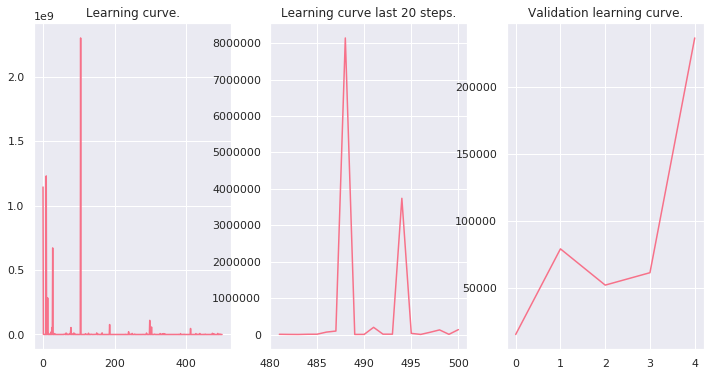

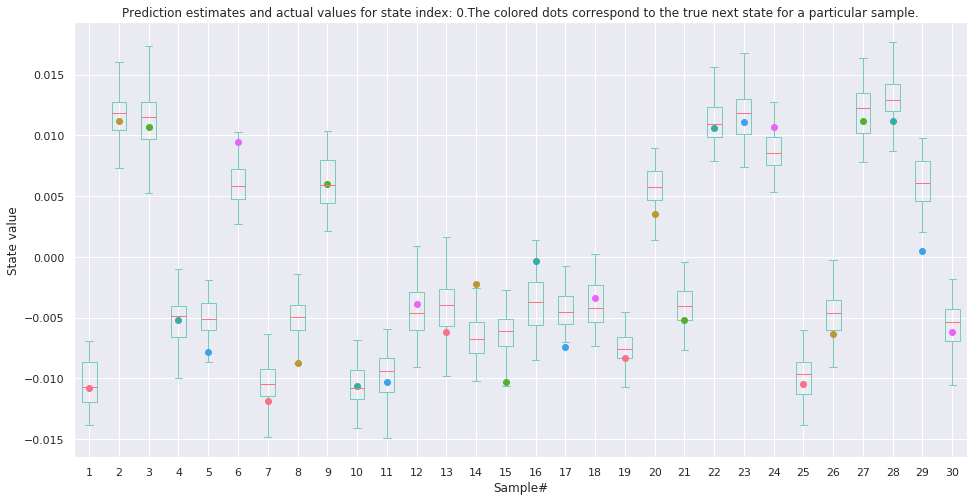

Param approx mean:  0.9838173598084338


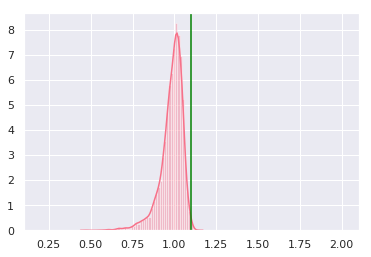

epoch: 600, loss: 21676.7520


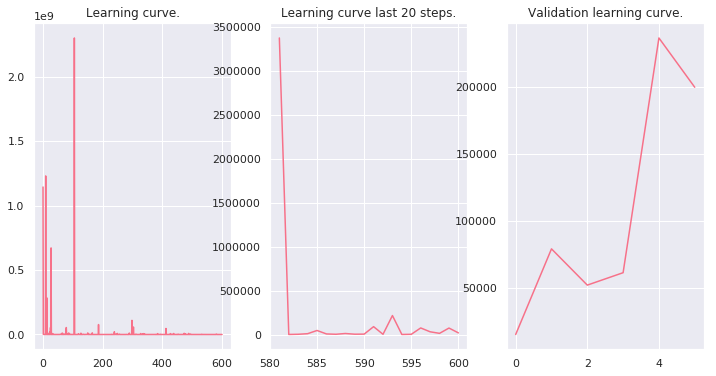

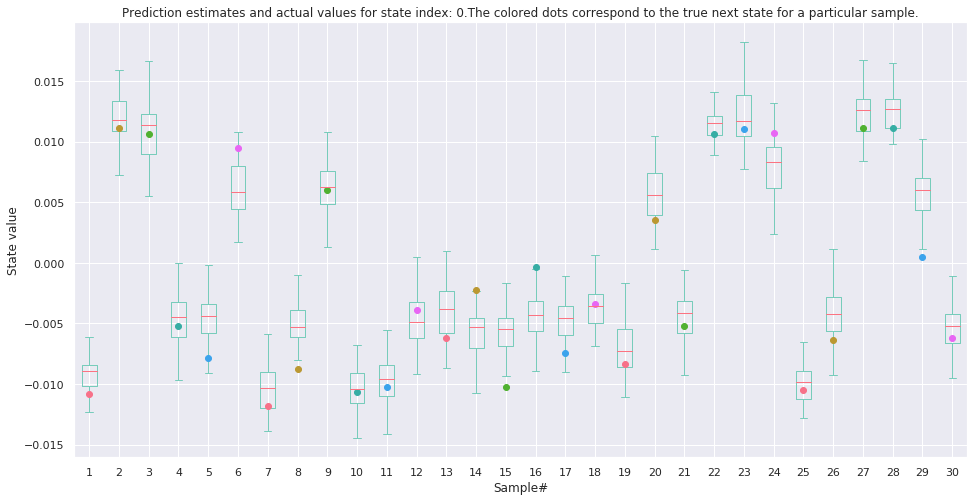

Param approx mean:  0.7849966817712981


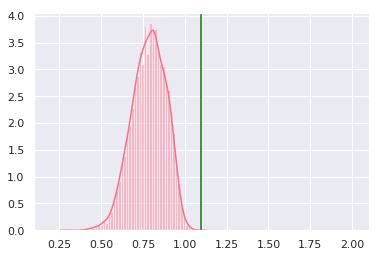

epoch: 700, loss: 4131.9351


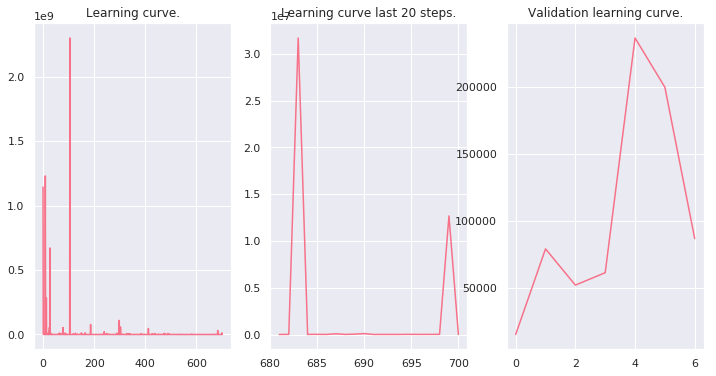

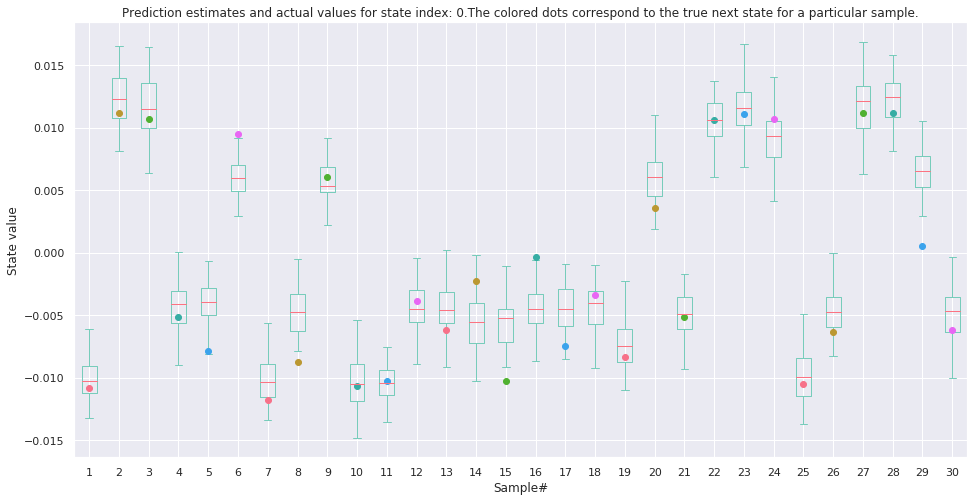

Param approx mean:  1.0552860815773542


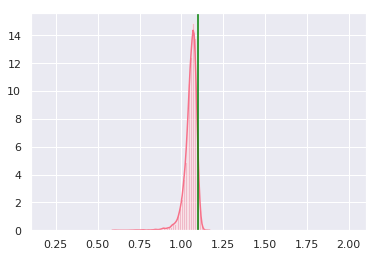

epoch: 800, loss: 6295.2549


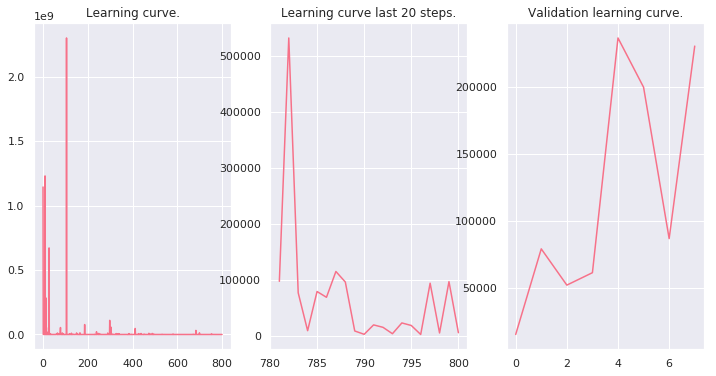

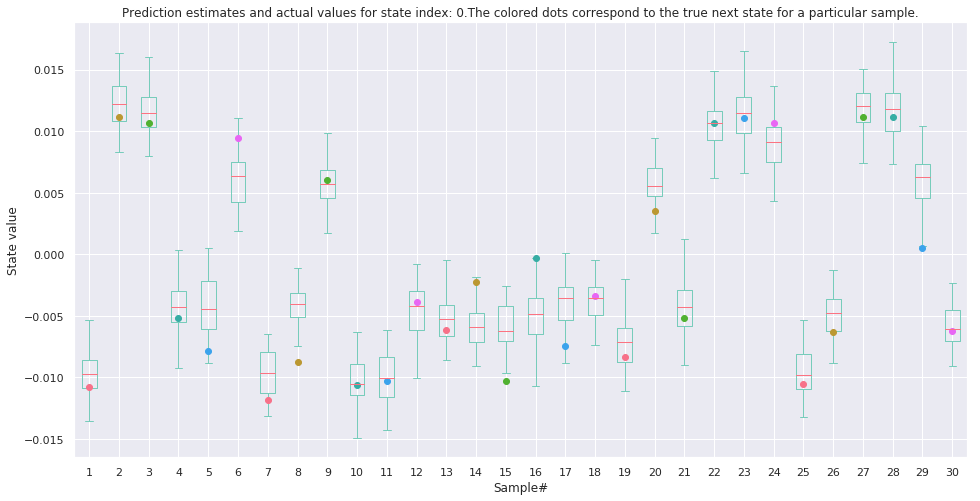

Param approx mean:  1.0782806607304678


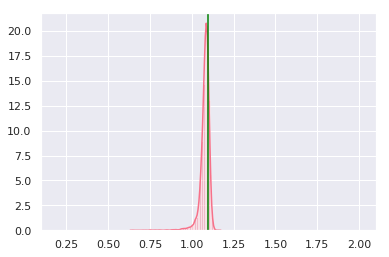

epoch: 900, loss: 8352.4248


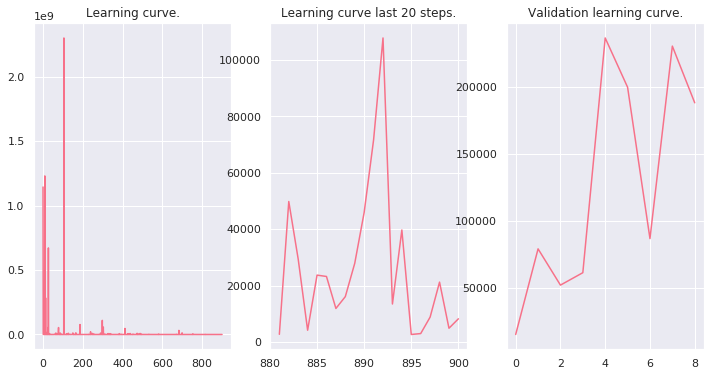

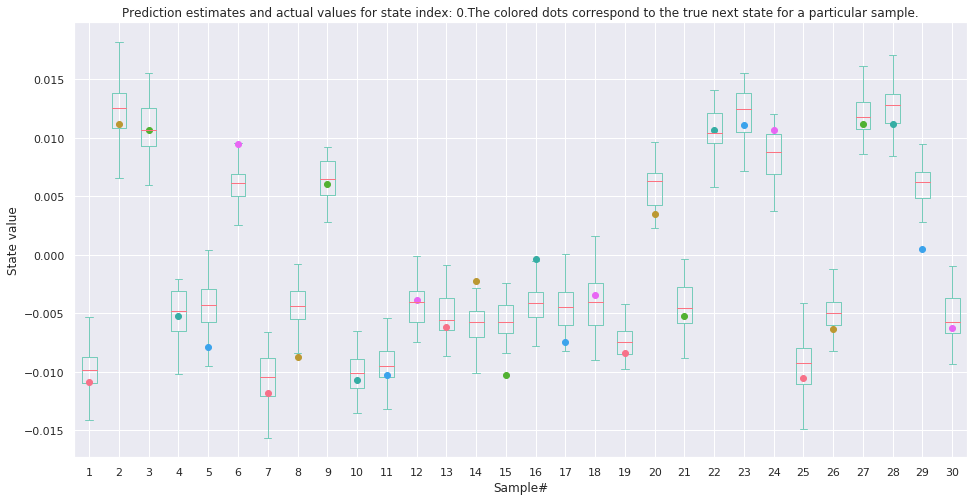

Param approx mean:  1.0811471623768


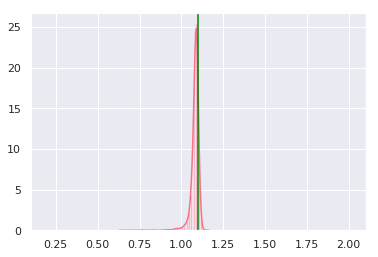

In [24]:
train_cvae(iterator, iterator_init_fn, encoder_optimizer, loss, n_epochs_cvae, n_trials, real_samples2plot)

Param approx mean:  1.0837333566060054


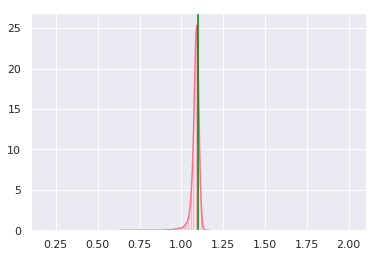

In [25]:
plot_posterior(posterior)

# Train on real data

epoch: 100, loss: 1319992192.0000


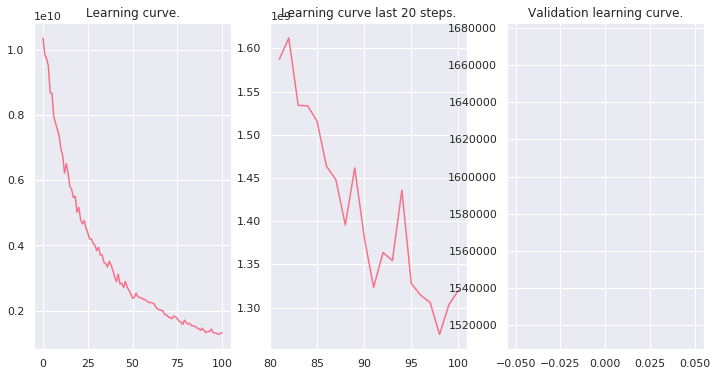

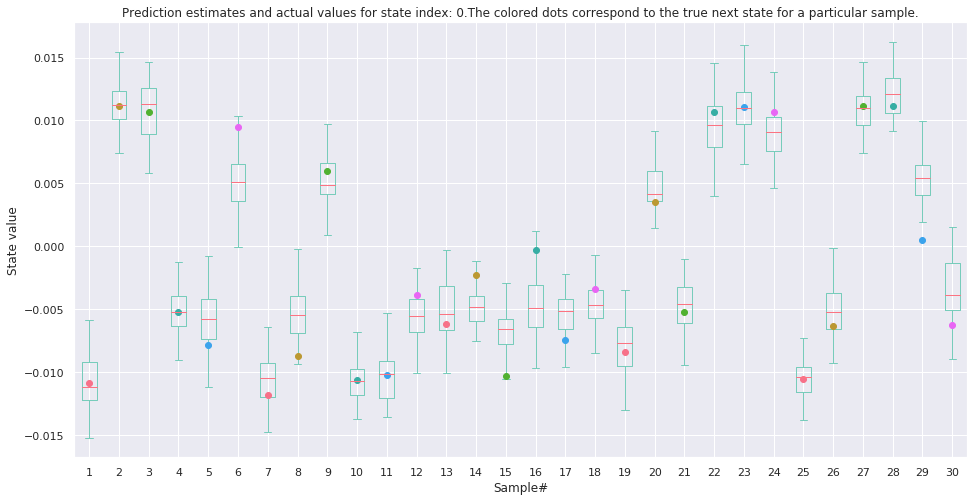

Param approx mean:  1.080986212478339


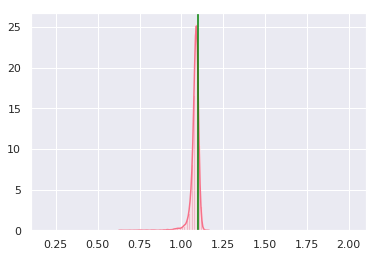

epoch: 200, loss: 541161984.0000


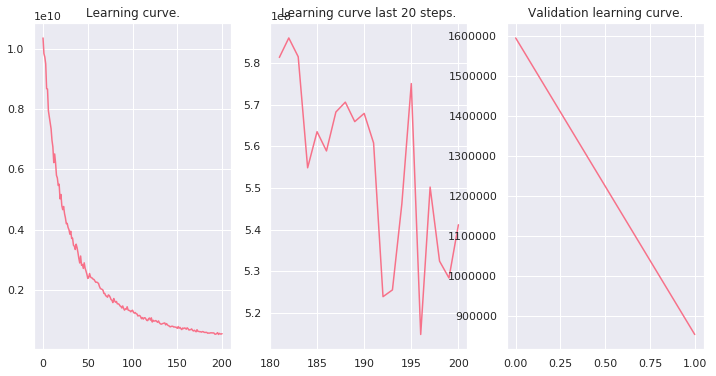

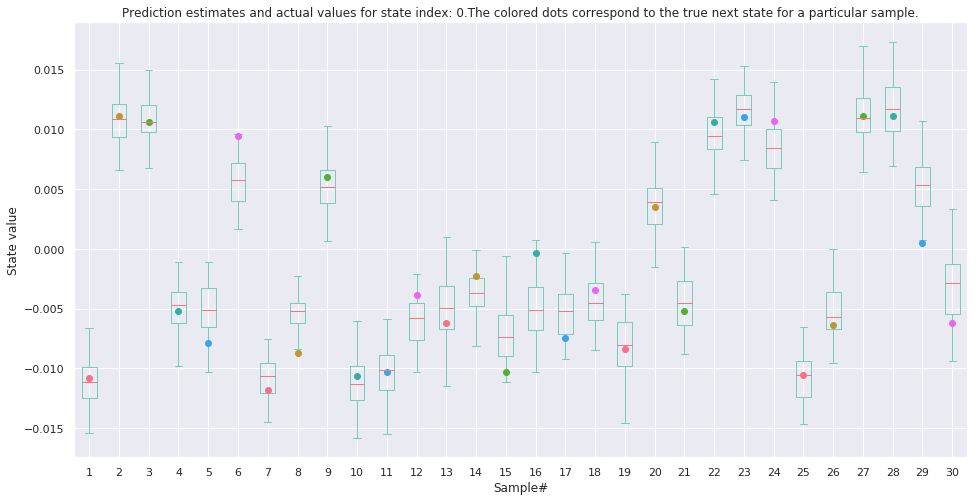

Param approx mean:  1.0807364228530074


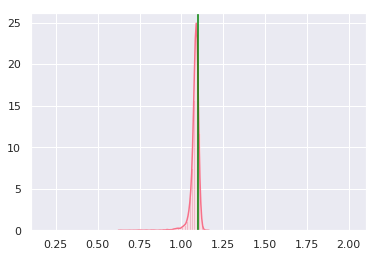

epoch: 300, loss: 293131936.0000


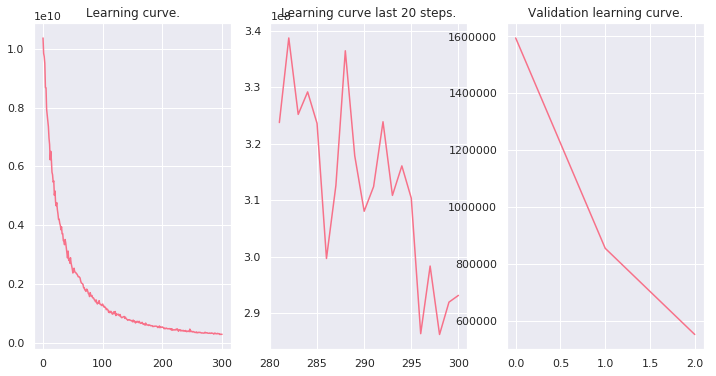

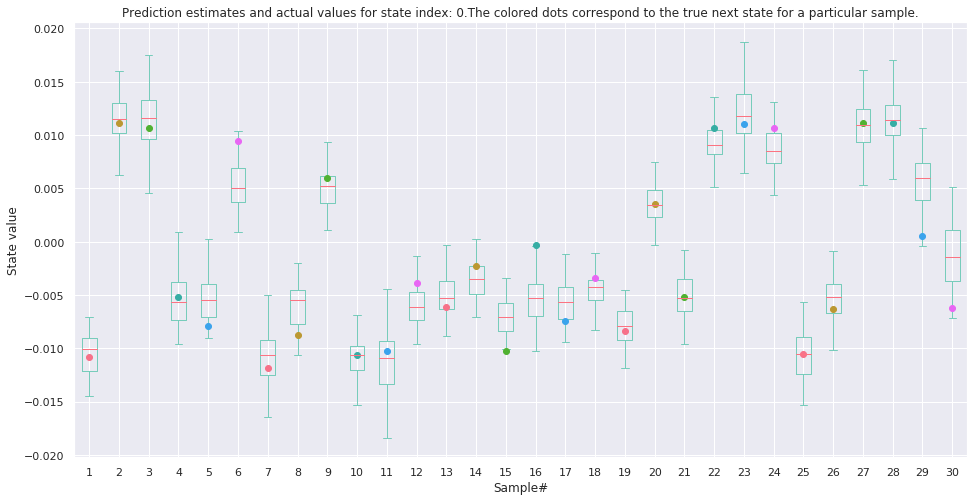

Param approx mean:  1.0807831401528285


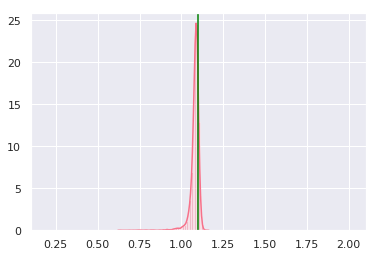

epoch: 400, loss: 202134512.0000


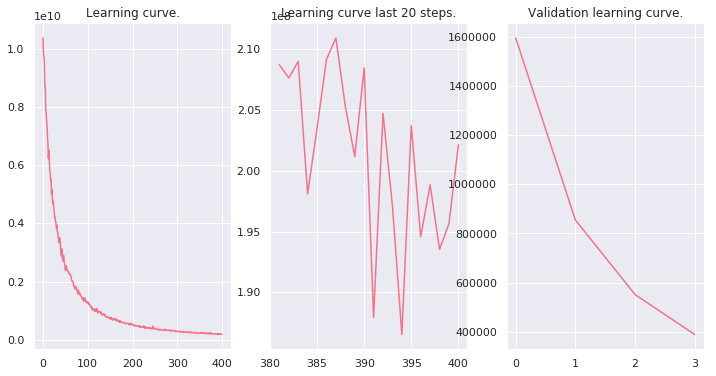

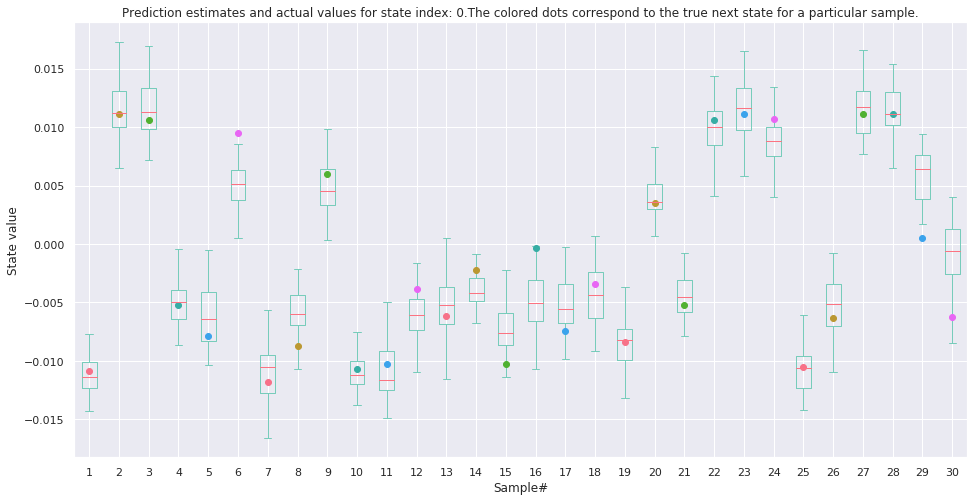

Param approx mean:  1.0810162170282334


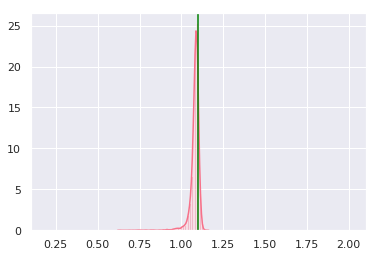

epoch: 500, loss: 143173136.0000


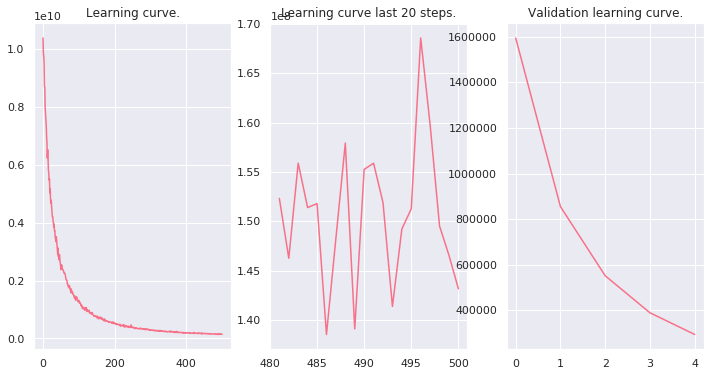

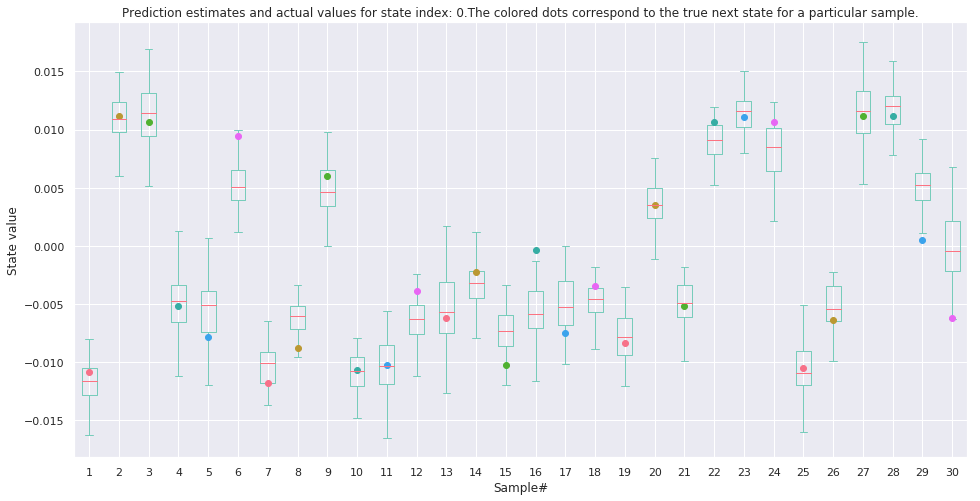

Param approx mean:  1.0812688390580907


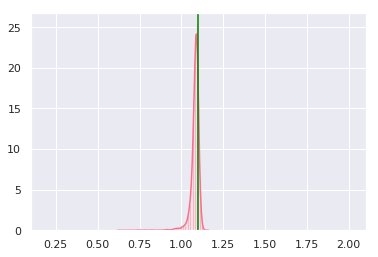

epoch: 600, loss: 121146040.0000


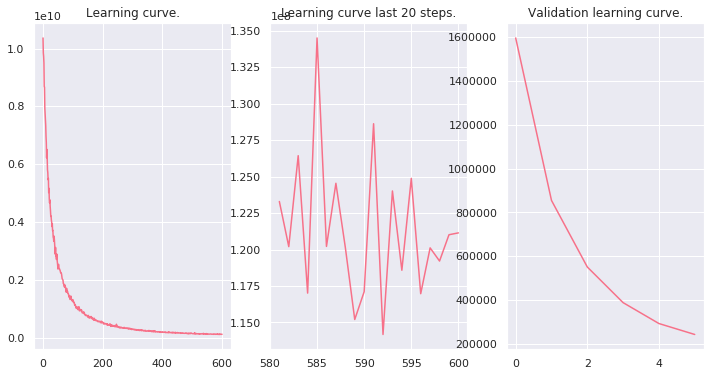

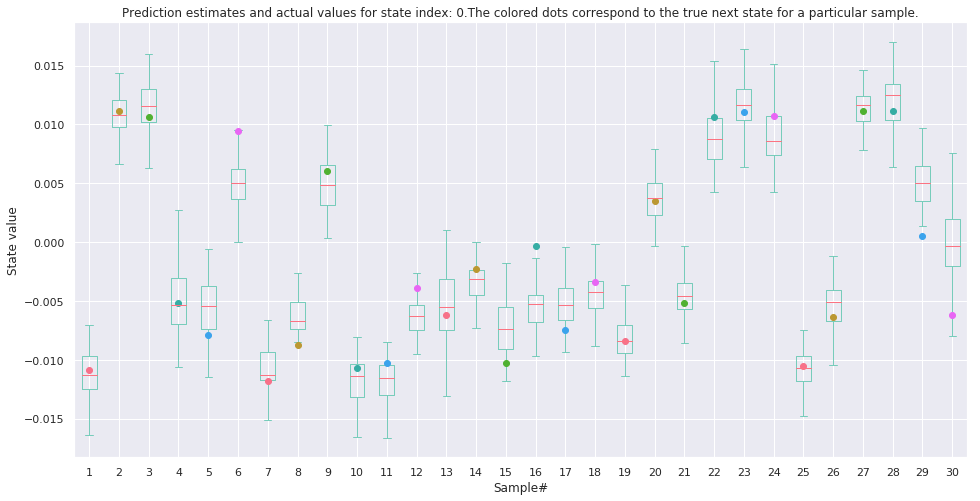

Param approx mean:  1.081481047814435


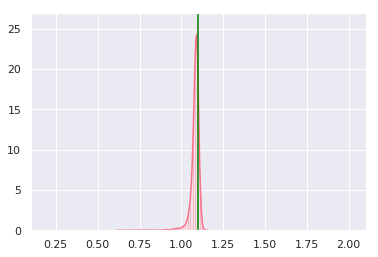

epoch: 700, loss: 99765360.0000


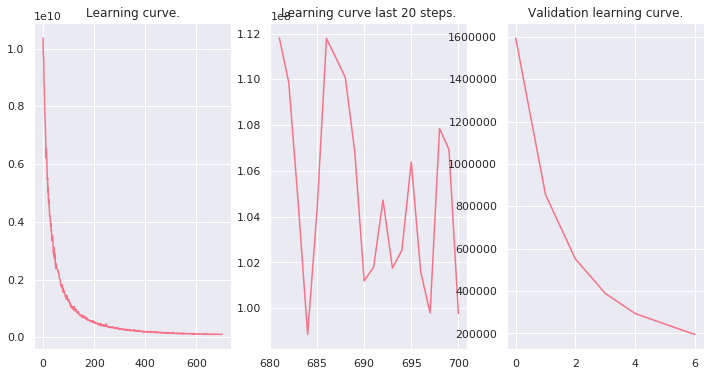

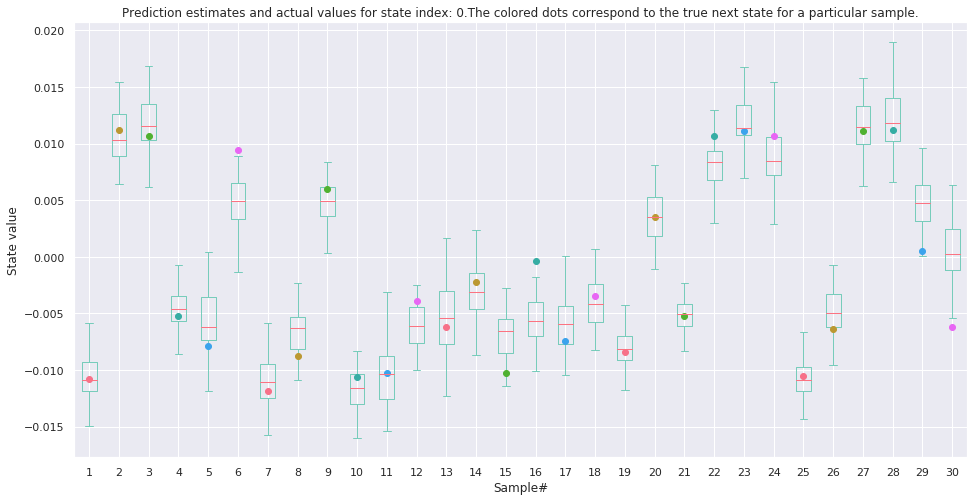

Param approx mean:  1.081619642865698


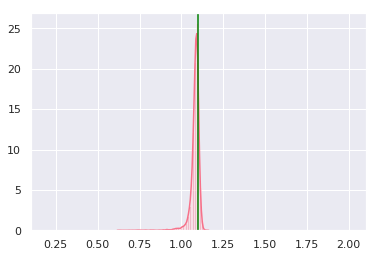

epoch: 800, loss: 106603152.0000


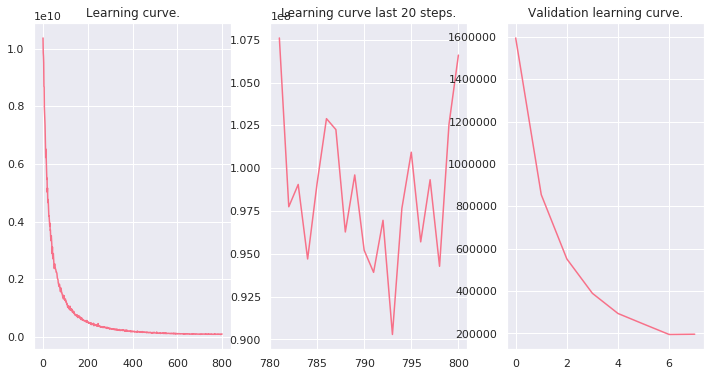

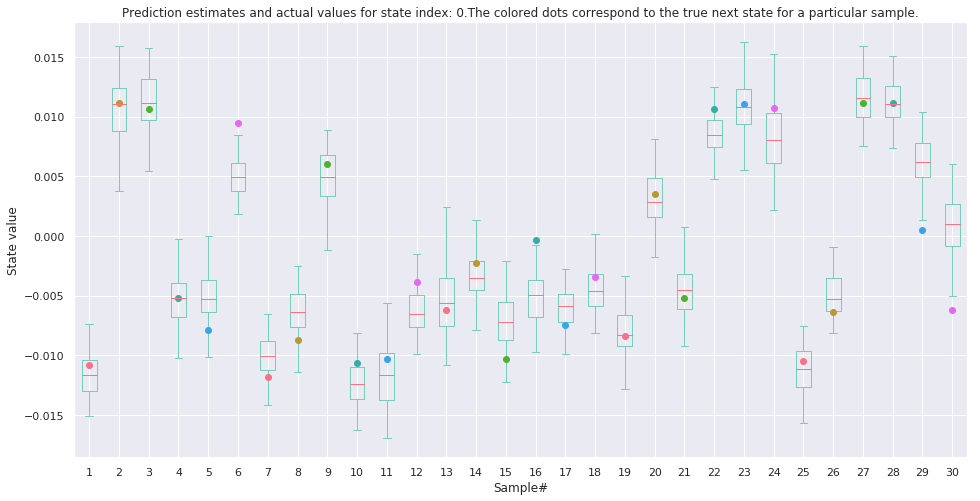

Param approx mean:  1.0817043765175467


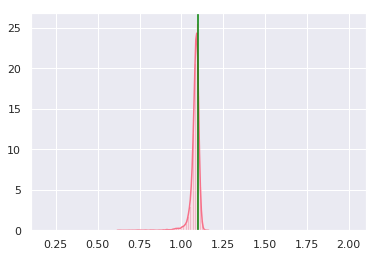

epoch: 900, loss: 97428824.0000


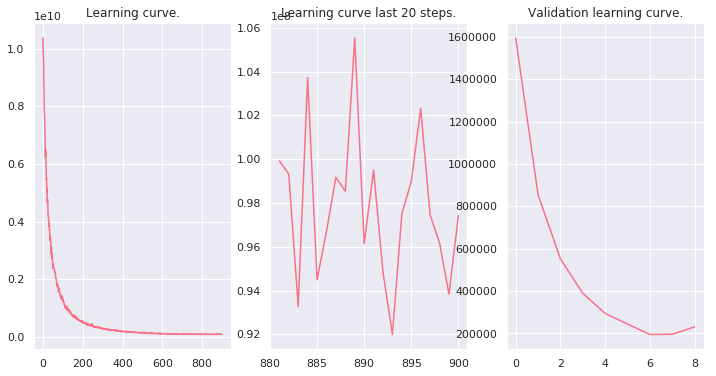

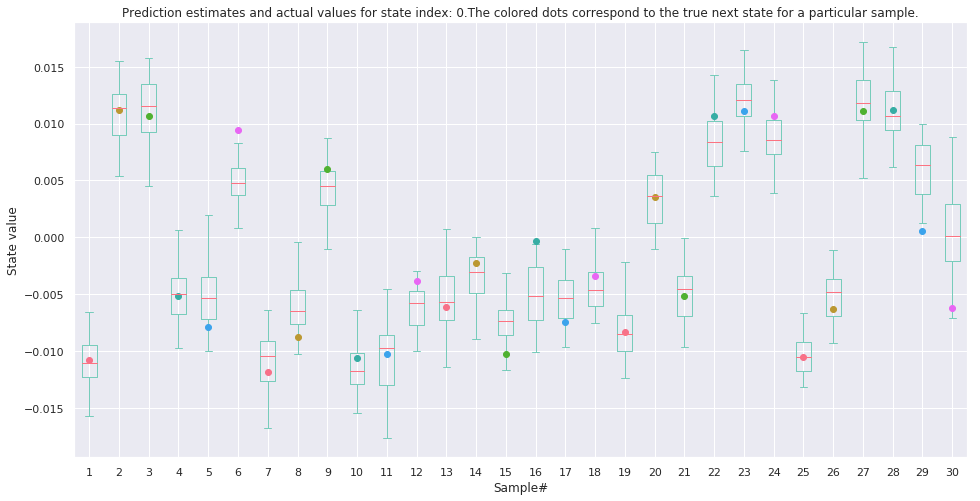

Param approx mean:  1.081716223885804


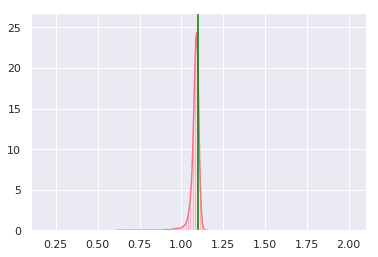

In [26]:
train_cvae(real_iterator, real_iterator_init_fn, optimizer, loss, n_epochs_cvae, n_trials, real_samples2plot)

Param approx mean:  1.081716223885804
Mean of simulated params:  -0.03297954382860929


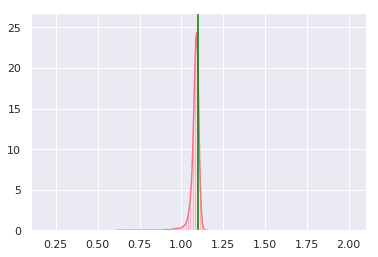

In [27]:
plot_posterior(posterior)
print('Mean of simulated params: ', np.mean(params))